In [1]:
import sys
sys.path.append("..")

from methods.dcbo import DynCausalBayesOpt
from utils.sequential_sampling import draw_samples_from_sem_dev
from causal_graph.example_dyn_graphs import three_step_stat
from sem.stationary import StationaryModel_dev
from collections import OrderedDict
from utils.costs import equal_cost
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from collections import OrderedDict
tfd = tfp.distributions
tf.random.set_seed(0)

In [2]:
sem_model = StationaryModel_dev()
num_samples = 80
temporal_index = 2
full_samples = OrderedDict([(key, []) for key in sem_model.static().keys()])
epsilon = OrderedDict(
    [
        (key, tfd.Normal(0.0, 1.0).sample((num_samples, temporal_index+1)))
        for key in full_samples.keys()
    ]
)
D_obs = draw_samples_from_sem_dev(sem_model, num_samples, temporal_index, epsilon=epsilon)

In [3]:
dyn_graph = three_step_stat()

intervention_ini = {
    "X": [-0.6],
    "Z": [None],
    "Y": [None],
}
D_intervene_ini_x = draw_samples_from_sem_dev(
    sem_model, 1, 0, intervention=intervention_ini, epsilon=0.0
)

intervention_ini = {
    "X": [None],
    "Z": [7.5],
    "Y": [None],
}
D_intervene_ini_z = draw_samples_from_sem_dev(
    sem_model, 1, 0, intervention=intervention_ini, epsilon=0.0
)
D_intervene_ini = OrderedDict(
    [(("X",), D_intervene_ini_x), (("Z",), D_intervene_ini_z)]
)
intervention_domain = OrderedDict([("X", [-3.0, 5.0]), ("Z", [-5.0, 20.0])])
dcbo = DynCausalBayesOpt(
    dyn_graph=dyn_graph,
    sem=sem_model,
    D_obs=D_obs,
    D_intervene_ini=D_intervene_ini,
    intervention_domain=intervention_domain,
    num_trials=10,
    task="min",
    cost_fcn=equal_cost,
    num_anchor_points= 100,
    num_monte_carlo= 100,
    ini_global_extreme_abs=10.0,
    jitter= 1e-6,
    learning_rate=1e-5,
    intervene_noise_factor=1e-4,
    observation_noise_factor=1e-2,
    max_training_step=30000,
    debug_mode=False,
)

In [4]:
opt_history = dcbo.run()

Dynamic causal Bayesian optimization at time step 0 is started.
Temporal index: 0 . Trial: 0
Intervened exploration set: ('Z',) . Intervention point: [[-2.681889]] . Target variable value: -2.0396848
Optimal value: -2.0396848
Temporal index: 0 . Trial: 1
Intervened exploration set: ('X',) . Intervention point: [[4.6312084]] . Target variable value: 0.00043958426
Optimal value: -2.0396848
Temporal index: 0 . Trial: 2
Intervened exploration set: ('X',) . Intervention point: [[-2.2077522]] . Target variable value: -1.5807936
Optimal value: -2.0396848
Temporal index: 0 . Trial: 3
Intervened exploration set: ('Z',) . Intervention point: [[8.847605]] . Target variable value: -1.4805138
Optimal value: -2.0396848
Temporal index: 0 . Trial: 4
Intervened exploration set: ('Z',) . Intervention point: [[4.2739553]] . Target variable value: -1.2321142
Optimal value: -2.0396848
Temporal index: 0 . Trial: 5
Intervened exploration set: ('Z',) . Intervention point: [[2.7933402]] . Target variable value

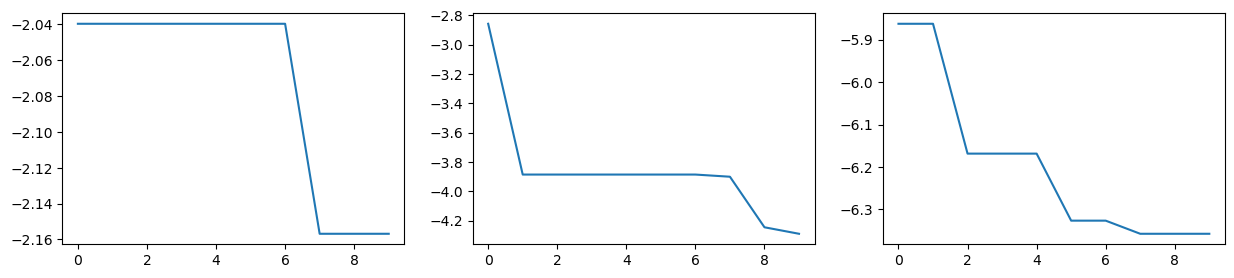

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for i in range(3):
    axs[i].plot(opt_history[i])
plt.show()